# Expected Goals per Player as a metric for Best Goalers
### Note: Notebook has limited rendering on github. Kindly use NBviewer to see plotly graphs in this notebook: https://nbviewer.jupyter.org/

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/xg-summary/Summary_ixG.csv
/kaggle/input/mikyla-xg/Mikyla_xG.png
/kaggle/input/all-stats/all_events_stats.xlsx
/kaggle/input/mikyla-xg-labelled/Mikyla_xG_Labelled.png
/kaggle/input/xg-summary-goals/Summary_ixG_Goals.csv
/kaggle/input/input-data/Rotman MMA Summer Datathon NWHL.csv


In [2]:
nwhl_df = pd.read_csv("../input/input-data/Rotman MMA Summer Datathon NWHL.csv")
nwhl_df.head()

,game_date,Home Team,Away Team,Period,Clock,Home Team Skaters,Away Team Skaters,Home Team Goals,Away Team Goals,Team,...,Event,X Coordinate,Y Coordinate,Detail 1,Detail 2,Detail 3,Detail 4,Player 2,X Coordinate 2,Y Coordinate 2
0,2021-01-23,Minnesota Whitecaps,Boston Pride,1,20:00,5,5,0,0,Boston Pride,...,Faceoff Win,100,43,Backhand,NaN,NaN,NaN,Stephanie Anderson,NaN,NaN
1,2021-01-23,Minnesota Whitecaps,Boston Pride,1,19:58,5,5,0,0,Boston Pride,...,Puck Recovery,107,40,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2021-01-23,Minnesota Whitecaps,Boston Pride,1,19:57,5,5,0,0,Boston Pride,...,Zone Entry,125,28,Carried,NaN,NaN,NaN,Maddie Rowe,NaN,NaN
3,2021-01-23,Minnesota Whitecaps,Boston Pride,1,19:55,5,5,0,0,Boston Pride,...,Shot,131,28,Snapshot,On Net,t,f,NaN,NaN,NaN
4,2021-01-23,Minnesota Whitecaps,Boston Pride,1,19:53,5,5,0,0,Boston Pride,...,Faceoff Win,169,21,Backhand,NaN,NaN,NaN,Stephanie Anderson,NaN,NaN


In [3]:
import math

xG=[]
for index,row in nwhl_df.iterrows():
    if row['Event']=='Shot' or row['Event']=='Goal':
        if row['Detail 2'] !='Blocked':
            dist=math.sqrt(((200-row['X Coordinate'])**2)+((42.5-row['Y Coordinate'])**2))
            slope = math.tan((42.5-row['Y Coordinate'])/(200-row['X Coordinate']))
            if row['Event']=='Goal':
                xG.append([row['Player'],row['Event'],row['X Coordinate'],row['Y Coordinate'], dist, slope, row['Detail 1'],row['Detail 2'], row['Period'], row['Home Team Skaters'], row['Away Team Skaters'], 1])
            if row['Event']=='Shot':
                xG.append([row['Player'],row['Event'],row['X Coordinate'],row['Y Coordinate'], dist, slope, row['Detail 1'],row['Detail 2'], row['Period'], row['Home Team Skaters'], row['Away Team Skaters'], 0])

xG_df=pd.DataFrame(xG,columns=['Player','Event','X','Y','Distance','Slope','Type','Detail','Period', 'Home Team Skaters', 'Away Team Skaters', 'Result'])
xG_df.head()

,Player,Event,X,Y,Distance,Slope,Type,Detail,Period,Home Team Skaters,Away Team Skaters,Result
0,McKenna Brand,Shot,131,28,70.507092,0.213294,Snapshot,On Net,1,5,5,0
1,Allie Thunstrom,Shot,162,2,55.536024,1.808902,Snapshot,On Net,1,5,5,0
2,Nina Rodgers,Shot,167,18,41.100487,0.917545,Snapshot,Missed,1,5,5,0
3,McKenna Brand,Shot,175,68,35.710643,-1.628130,Snapshot,On Net,1,5,5,0
4,Lauren Kelly,Shot,196,20,22.852790,-0.773201,Snapshot,On Net,1,5,5,0


In [4]:
len(xG_df['Player'].unique())

111

In [5]:
all_players = nwhl_df['Player'].unique()
xG_players = xG_df['Player'].unique()

print("Players whose xG won't be calculated: ")
set(all_players) ^ set(xG_players)

Players whose xG won't be calculated: 


{'Abbie Ives',
 'Amanda Leveille',
 'Brooke Avery',
 'Brooke White',
 'Brooke Wolejko',
 'Carly Jackson',
 'Caty Flagg',
 'Elaine Chuli',
 'Lovisa Selander',
 'Mariah Fujimagari',
 'Rose Alleva',
 'Samantha Ridgewell',
 'Sonjia Shelly',
 'Tera Hofmann',
 'Victoria Hanson'}

In [6]:
# Splitting

x_train = xG_df[['Distance', 'Slope', 'Type', 'Detail', 'Period', 'Home Team Skaters', 'Away Team Skaters']]
y_train = xG_df[['Result']]

x_test = xG_df[['Distance', 'Slope', 'Type', 'Detail', 'Period', 'Home Team Skaters', 'Away Team Skaters']]
y_test = xG_df[['Result']]

In [7]:
# Encoding
pd.options.mode.chained_assignment = None

x_train['Type'] = x_train['Type'].astype('category')
x_train['Type'] = x_train['Type'].cat.codes
x_test['Type'] = x_test['Type'].astype('category')
x_test['Type'] = x_test['Type'].cat.codes

x_train['Detail'] = x_train['Detail'].astype('category')
x_train['Detail'] = x_train['Detail'].cat.codes
x_test['Detail'] = x_test['Detail'].astype('category')
x_test['Detail'] = x_test['Detail'].cat.codes

In [8]:
x_train.head()

,Distance,Slope,Type,Detail,Period,Home Team Skaters,Away Team Skaters
0,70.507092,0.213294,3,1,1,5,5
1,55.536024,1.808902,3,1,1,5,5
2,41.100487,0.917545,3,0,1,5,5
3,35.710643,-1.628130,3,1,1,5,5
4,22.852790,-0.773201,3,1,1,5,5


In [9]:
# Feature Scaling

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

In [10]:
## Handling Imbalanced Data using SMOTE
print("Shape of training data before SMOTE: {} and {}".format(x_train.shape, y_train.shape))

from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state = 0)
x_train_res, y_train_res = sm.fit_resample(x_train, y_train)
print("Shape of training data after synthetic oversampling: {} and {} ".format(x_train_res.shape, y_train_res.shape))

Shape of training data before SMOTE: (1420, 7) and (1420, 1)
Shape of training data after synthetic oversampling: (2688, 7) and (2688, 1) 


In [11]:
## Shape of training data after synthetic oversampling
print("Value counts before synthetic minority oversampling:\n", y_train.value_counts())
print("\n")
print("Value counts after synthetic minority oversampling:\n", y_train_res.value_counts())

Value counts before synthetic minority oversampling:
 Result
0         1344
1           76
dtype: int64


Value counts after synthetic minority oversampling:
 Result
0         1344
1         1344
dtype: int64


**SMOTE is Synthetic Minority Oversampling Technique - overcoming the overfitting problem and class imbalance problem by generating synthetic minority records by random over-sampling**

## Baseline Models

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay,precision_score, recall_score, f1_score, classification_report, roc_auc_score, roc_curve, plot_roc_curve, precision_recall_curve, plot_precision_recall_curve, auc, average_precision_score

from sklearn.model_selection import cross_val_score

In [13]:
models_array = []

## Adding it in an array so that could be made into a dataframe later
models_array.append(['Logistic Regression', LogisticRegression(random_state = 0)])
models_array.append(['K Nearest Neighbours', KNeighborsClassifier()])
#models_array.append(['SVM Classifier', SVC(random_state=0)])
models_array.append(['Gaussian Naive Bayes', GaussianNB()])
models_array.append(['Bernoulli Naive Bayes', BernoulliNB()])
models_array.append(['Decision Tree Classifier', DecisionTreeClassifier(random_state = 0)])
models_array.append(['Random Forest', RandomForestClassifier(random_state = 0)])
models_array.append(['XGBoost Classifier', XGBClassifier(eval_metric = 'error',use_label_encoder=False)])

In [14]:
list1= []

for m in range(len(models_array)):
    list2 = []
    model = models_array[m][1]
    model.fit(x_train_res, y_train_res.values.ravel())
    y_pred = model.predict(x_test)
    y_prob = model.predict_proba(x_test)
    
    # confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # training accuracies - K-fold cross validation
    accuracies = cross_val_score(estimator = model, X = x_train_res, y = y_train_res.values.ravel(), cv = 10)
    
    # Accuracy score of test set
    accuracy = accuracy_score(y_test, y_pred)
    
    # Area Score under Reciever Operating Characteristic Curve
    roc = roc_auc_score(y_test, y_pred) 
    
    # Precision
    precision = precision_score(y_test, y_pred)
    
    # Recall
    recall = recall_score(y_test, y_pred)
    
    # F1-score
    f1 = f1_score(y_test, y_pred)
    
    # Printing the results for every model
    print("----------------------------------------")
    print(models_array[m][0], ":")
    print("Training set mean accuracy: {:.2f} %".format(accuracies.mean()*100))
    print("Training set standard deviation: {:.2f} %".format(accuracies.std()*100))
    print("Test set accuracy: {:.2f} %".format(accuracy*100))
    print("Confusion Matrix: ", cm)
    print("Precision: {:.2f} %".format(precision*100))
    print("Recall: {:.2f} %".format(recall*100))
    print("F1 score: {:.2f}".format(f1))
    print("AUROC score: {:.2f}".format(roc))
    print("-----------------------------------------")
    print("\n")
    
    ## Adding all scores to a list so that we can form a dataframe later
    list2.append(models_array[m][0])
    list2.append(accuracies.mean()*100)
    list2.append(accuracies.std()*100)
    list2.append(accuracy)
    list2.append(precision)
    list2.append(recall)
    list2.append(f1)
    list2.append(roc)
    
    list1.append(list2)

----------------------------------------
Logistic Regression :
Training set mean accuracy: 74.37 %
Training set standard deviation: 3.08 %
Test set accuracy: 64.93 %
Confusion Matrix:  [[861 483]
 [ 15  61]]
Precision: 11.21 %
Recall: 80.26 %
F1 score: 0.20
AUROC score: 0.72
-----------------------------------------


----------------------------------------
K Nearest Neighbours :
Training set mean accuracy: 86.91 %
Training set standard deviation: 2.09 %
Test set accuracy: 87.89 %
Confusion Matrix:  [[1174  170]
 [   2   74]]
Precision: 30.33 %
Recall: 97.37 %
F1 score: 0.46
AUROC score: 0.92
-----------------------------------------


----------------------------------------
Gaussian Naive Bayes :
Training set mean accuracy: 68.42 %
Training set standard deviation: 2.22 %
Test set accuracy: 40.99 %
Confusion Matrix:  [[508 836]
 [  2  74]]
Precision: 8.13 %
Recall: 97.37 %
F1 score: 0.15
AUROC score: 0.68
-----------------------------------------


-----------------------------------

/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


----------------------------------------
XGBoost Classifier :
Training set mean accuracy: 91.63 %
Training set standard deviation: 3.60 %
Test set accuracy: 98.80 %
Confusion Matrix:  [[1328   16]
 [   1   75]]
Precision: 82.42 %
Recall: 98.68 %
F1 score: 0.90
AUROC score: 0.99
-----------------------------------------




In [15]:
## Grid search for hyperparameter tuning
from sklearn.model_selection import GridSearchCV

grid_models = [
    (LogisticRegression(), [{'C':[0.25, 0.5, 0.75, 1], 'random_state':[0]}]),
    #(KNeighborsClassifier(), [{'n_neighbors': [5,7,8,10], 'metric': ['euclidian', 'manhattan', 'chebyshev', 'minkowski']}]),
    #(SVC(), [{'C': [0.25, 0.5, 0.75, 1], 'kernel': ['linear', 'rbf'], 'random_state':[0]}]),
    (GaussianNB(), [{'var_smoothing': [1e-09]}]),
    (BernoulliNB(), [{'alpha': [0.25, 0.5, 1]}]),
    (DecisionTreeClassifier(), [{'criterion': ['gini', 'entropy'], 'random_state': [0]}]),
    (RandomForestClassifier(), [{'n_estimators': [100, 150, 200], 'criterion': ['gini', 'entropy'], 'random_state': [0]}]),
    (XGBClassifier(), [{'learning_rate': [0.01, 0.05, 0.1], 'eval_metric': ['error'], 'use_label_encoder': [False]}])
]

In [16]:
for i,j in grid_models:
    grid = GridSearchCV(estimator = i, param_grid = j, scoring = 'accuracy', cv = 10)
    grid.fit(x_train_res, y_train_res.values.ravel())
    best_accuracy = grid.best_score_
    best_param = grid.best_params_
    
    print("{}: ", i)
    print("Best Accuracy:  {:.2f} %".format(best_accuracy*100))
    print("Best parameters selected: ", best_param)
    print("------------------------------")
    print("\n")

{}:  LogisticRegression()
Best Accuracy:  74.41 %
Best parameters selected:  {'C': 0.5, 'random_state': 0}
------------------------------


{}:  GaussianNB()
Best Accuracy:  68.42 %
Best parameters selected:  {'var_smoothing': 1e-09}
------------------------------


{}:  BernoulliNB()
Best Accuracy:  75.00 %
Best parameters selected:  {'alpha': 0.25}
------------------------------


{}:  DecisionTreeClassifier()
Best Accuracy:  87.65 %
Best parameters selected:  {'criterion': 'gini', 'random_state': 0}
------------------------------


{}:  RandomForestClassifier()
Best Accuracy:  92.37 %
Best parameters selected:  {'criterion': 'gini', 'n_estimators': 200, 'random_state': 0}
------------------------------


{}:  XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, m

## Prediction using Tuned Models

In [17]:
# importing all metrics
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay,precision_score, recall_score, f1_score, classification_report, roc_auc_score, roc_curve, plot_roc_curve, precision_recall_curve, plot_precision_recall_curve, auc, average_precision_score

from sklearn.model_selection import cross_val_score

**Random Forest**

In [18]:
y_test

,Result
0,0
1,0
2,0
3,0
4,0
...,...
1415,0
1416,0
1417,0
1418,0


In [19]:
classifier = RandomForestClassifier(criterion = 'gini', n_estimators = 200, random_state = 0)
classifier.fit(x_train_res, y_train_res.values.ravel())
y_pred_rf = classifier.predict(x_test)
y_prob_rf = classifier.predict_proba(x_test)[:,1] #probability with which the prediction is made
cm = confusion_matrix(y_test, y_pred_rf)



rf_results_df = pd.DataFrame({'Predicted xG': y_pred_rf, 
                             'Predicted xG Probability': y_prob_rf,
                             'Actual xG': y_test.values.ravel()
                             })
rf_results_df.head()

,Predicted xG,Predicted xG Probability,Actual xG
0,0,0.050,0
1,0,0.000,0
2,0,0.000,0
3,0,0.015,0
4,0,0.160,0


In [20]:
print(classification_report(y_test, y_pred))
print("ROC AUC Score: ", roc_auc_score(y_test, y_prob_rf))
print("Test Accuracy: ", accuracy_score(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1344
           1       0.82      0.99      0.90        76

    accuracy                           0.99      1420
   macro avg       0.91      0.99      0.95      1420
weighted avg       0.99      0.99      0.99      1420

ROC AUC Score:  0.9999951049498746
Test Accuracy:  0.9992957746478873


AUC of tuned RF is:  0.9999951049498746


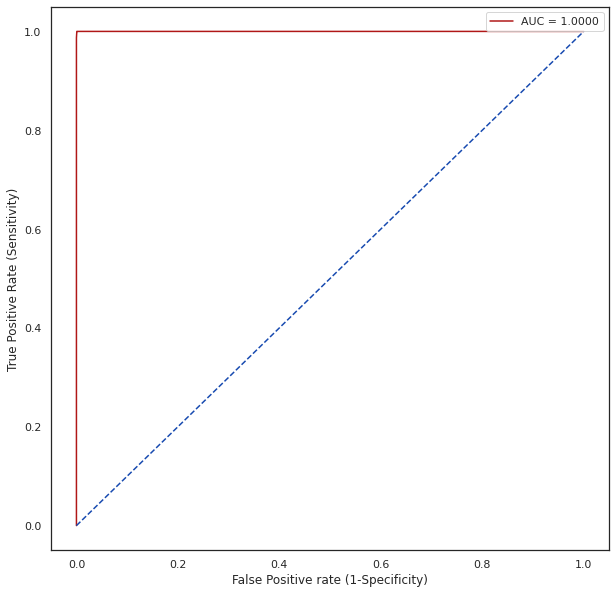

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

# Visualizing the ROC-AUC curve
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_prob_rf)
roc_auc_score = auc(false_positive_rate, true_positive_rate)
roc1 = roc_auc_score
print("AUC of tuned RF is: ", roc_auc_score)


# Visualizing the ROC curve

sns.set_theme(style = 'white')
plt.figure(figsize = (10,10))
plt.plot(false_positive_rate, true_positive_rate, color='#b01717', label = 'AUC = %0.4f' %roc_auc_score)
plt.legend(loc = 'lower right')
plt.plot([0,1], [0,1], linestyle='--', color = '#174ab0')
plt.axis('tight') # to remove additional white space in the plot
plt.ylabel('True Positive Rate (Sensitivity)')
plt.xlabel('False Positive rate (1-Specificity)')
plt.legend()
plt.show()

### RF seems to be clearly overfitted

In [22]:
classifier = XGBClassifier(eval_metric = 'error', use_label_encoder = False, learning_rate = 0.1)
classifier.fit(x_train_res, y_train_res)
y_pred_xgboost = classifier.predict(x_test)
y_prob_xgboost = classifier.predict_proba(x_test)[:,1]
cm = confusion_matrix(y_test, y_pred_xgboost)

df_xgboost_results = pd.DataFrame({'Predicted Goal(1) or Shot(0)': y_pred_xgboost, 
                                  'Predicted Goal Probability': y_prob_xgboost,
                                  'Actual Goal (1) or Shot (0)': y_test.values.ravel()})
df_xgboost_results.head()

/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


,Predicted Goal(1) or Shot(0),Predicted Goal Probability,Actual Goal (1) or Shot (0)
0,0,0.180660,0
1,0,0.006062,0
2,0,0.000863,0
3,0,0.064964,0
4,0,0.394736,0


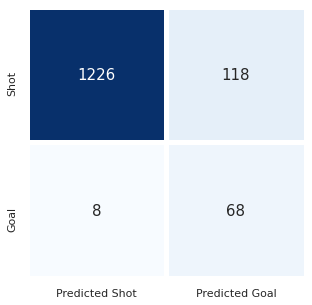

In [23]:
## Visualization - Confusion Matrix
plt.figure(figsize = (5,5))
sns.heatmap(cm, cmap = "Blues", annot = True, fmt = 'd', linewidth = 5, cbar = False, annot_kws = {'fontsize': 15},
           xticklabels = ['Predicted Shot', 'Predicted Goal'], yticklabels = ['Shot', 'Goal'])
plt.show()

In [24]:
accuracy_score(y_test, y_pred_xgboost)

0.9112676056338028

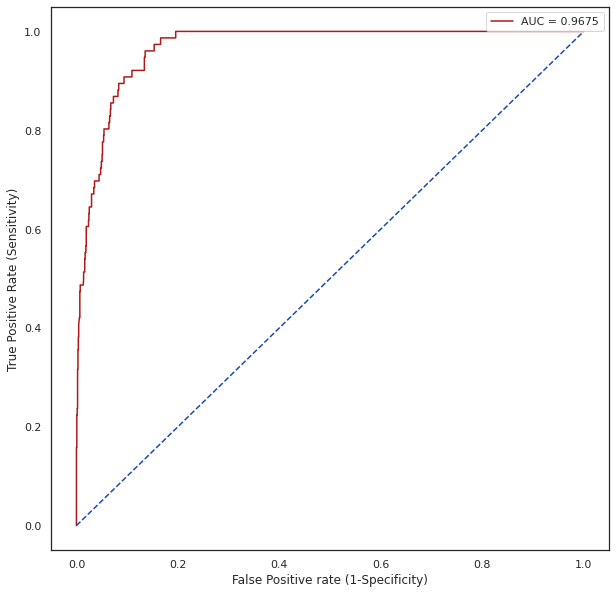

In [25]:
# ROC AUC curve
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_prob_xgboost)
roc_auc_score = auc(false_positive_rate, true_positive_rate)
roc_auc_score


## Visualizaton - ROC AUC Curve

sns.set_theme(style = 'white')
plt.figure(figsize = (10,10))
plt.plot(false_positive_rate, true_positive_rate, color='#b01717', label = 'AUC = %0.4f' %roc_auc_score)
plt.legend(loc = 'lower right')
plt.plot([0,1], [0,1], linestyle='--', color = '#174ab0')
plt.axis('tight') # to remove additional white space in the plot
plt.ylabel('True Positive Rate (Sensitivity)')
plt.xlabel('False Positive rate (1-Specificity)')
plt.legend()
plt.show()

## XG Boost performs much better than overfitted RF model, thus going forward with this prediction

In [26]:
y_prob_xgboost

array([0.18066035, 0.00606199, 0.0008631 , ..., 0.37572291, 0.01340992,
       0.00069988], dtype=float32)

In [27]:
xG_df['Predicted Result'] = y_pred_xgboost
xG_df['xG%'] = y_prob_xgboost
xG_df.head(10)

,Player,Event,X,Y,Distance,Slope,Type,Detail,Period,Home Team Skaters,Away Team Skaters,Result,Predicted Result,xG%
0,McKenna Brand,Shot,131,28,70.507092,0.213294,Snapshot,On Net,1,5,5,0,0,0.180660
1,Allie Thunstrom,Shot,162,2,55.536024,1.808902,Snapshot,On Net,1,5,5,0,0,0.006062
2,Nina Rodgers,Shot,167,18,41.100487,0.917545,Snapshot,Missed,1,5,5,0,0,0.000863
3,McKenna Brand,Shot,175,68,35.710643,-1.628130,Snapshot,On Net,1,5,5,0,0,0.064964
4,Lauren Kelly,Shot,196,20,22.852790,-0.773201,Snapshot,On Net,1,5,5,0,0,0.394736
5,Haylea Schmid,Shot,181,43,19.006578,-0.026322,Snapshot,On Net,1,5,5,0,1,0.666247
6,Lauren Kelly,Shot,163,10,49.246827,1.205677,Snapshot,On Net,1,5,5,0,0,0.006400
7,Samantha Davis,Shot,188,49,13.647344,-0.601697,Wrap Around,On Net,1,5,5,0,0,0.107491
8,Jillian Dempsey,Shot,149,19,56.153807,0.496426,Snapshot,On Net,1,5,5,0,0,0.144000
9,Jonna Curtis,Shot,167,67,41.100487,-0.917545,Snapshot,On Net,1,5,5,0,0,0.147233


In [28]:
xG_df[xG_df['Event']=='Goal']

,Player,Event,X,Y,Distance,Slope,Type,Detail,Period,Home Team Skaters,Away Team Skaters,Result,Predicted Result,xG%
20,Christina Putigna,Goal,175,44,25.044960,-0.060072,Snapshot,On Net,1,5,5,1,1,0.811328
25,Jonna Curtis,Goal,180,39,20.303941,0.176809,Snapshot,On Net,1,5,5,1,1,0.850586
53,Winny Brodt-Brown,Goal,188,55,17.327723,-1.710137,Snapshot,On Net,2,5,5,1,1,0.564506
123,Kayla Friesen,Goal,144,15,62.387899,0.534765,Snapshot,On Net,2,5,5,1,1,0.629735
159,Kristin Lewicki,Goal,168,28,35.131894,0.486915,Wristshot,On Net,3,5,4,1,1,0.668534
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1373,Kristin Lewicki,Goal,171,55,31.579265,-0.459874,Snapshot,On Net,2,5,5,1,1,0.828127
1384,Meaghan Rickard,Goal,167,55,35.288100,-0.398008,Snapshot,On Net,2,5,5,1,1,0.809464
1392,Lexie Laing,Goal,183,37,17.867568,0.335311,Wristshot,On Net,3,5,4,1,1,0.853921
1402,Mallory Souliotis,Goal,145,37,55.274316,0.100335,Wristshot,On Net,3,4,5,1,1,0.555811


In [29]:
xG_df.to_csv('Expected_Goal_Percentage.csv')

## Visualization of Expected Goals of a specific player (Mikyla) using the above dataset and Tableau

Goals and Shots with Expected Goal Distribution for Mikyla: 

Goals are Circles, Shots are Crosses
The gradient from green to grey to red represent decreasing xG value


AxesImage(100,100;620x604)


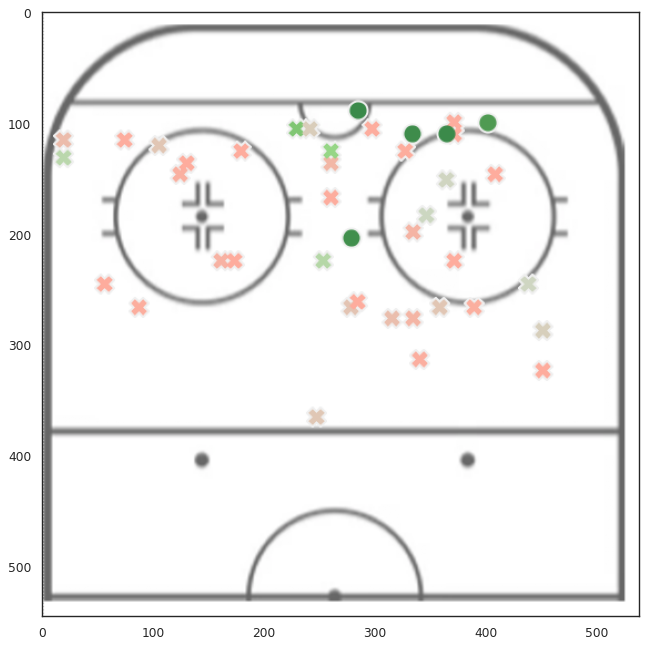

In [30]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
  
# Read Images
img = mpimg.imread('../input/mikyla-xg/Mikyla_xG.png')
  
# Output Images
fig = plt.figure(figsize=(10, 10), dpi=80)
print("Goals and Shots with Expected Goal Distribution for Mikyla: ")
print("\nGoals are Circles, Shots are Crosses")
print("The gradient from green to grey to red represent decreasing xG value\n\n")
print(plt.imshow(img))

Labelled Goals and Shots with Expected Goal Distribution for Mikyla: 


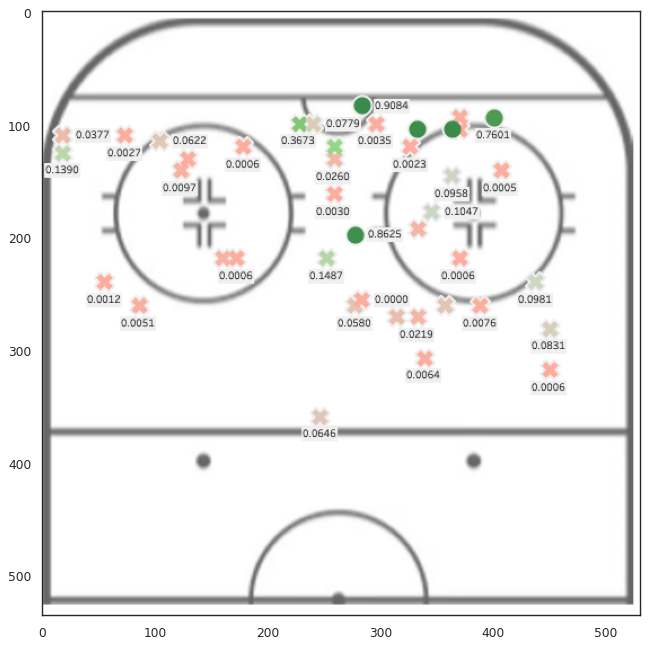

In [31]:
img_labelled = mpimg.imread('../input/mikyla-xg-labelled/Mikyla_xG_Labelled.png')
  
# Output Images
fig = plt.figure(figsize=(10, 10), dpi=80)
print("Labelled Goals and Shots with Expected Goal Distribution for Mikyla: ")
plt.imshow(img_labelled)

## Finding average expected Goal % for each player

In [32]:
xG_df.head()

,Player,Event,X,Y,Distance,Slope,Type,Detail,Period,Home Team Skaters,Away Team Skaters,Result,Predicted Result,xG%
0,McKenna Brand,Shot,131,28,70.507092,0.213294,Snapshot,On Net,1,5,5,0,0,0.180660
1,Allie Thunstrom,Shot,162,2,55.536024,1.808902,Snapshot,On Net,1,5,5,0,0,0.006062
2,Nina Rodgers,Shot,167,18,41.100487,0.917545,Snapshot,Missed,1,5,5,0,0,0.000863
3,McKenna Brand,Shot,175,68,35.710643,-1.628130,Snapshot,On Net,1,5,5,0,0,0.064964
4,Lauren Kelly,Shot,196,20,22.852790,-0.773201,Snapshot,On Net,1,5,5,0,0,0.394736


In [33]:
grouped_xG_df = xG_df.groupby(['Player','xG%'])
grouped_xG_df.first()

Event    X   Y   Distance     Slope       Type  \
Player            xG%                                                       
Allie Olnowich    0.001707  Shot  136  63  67.203051 -0.331736  Wristshot   
                  0.002906  Shot  167  62  38.330797 -0.670873   Snapshot   
                  0.021650  Shot  154  83  61.288253 -1.210736   Snapshot   
                  0.023129  Shot  151  76  59.356971 -0.814755  Wristshot   
                  0.046421  Shot  149  83  65.124880 -1.017593   Snapshot   
...                          ...  ...  ..        ...       ...        ...   
Whitney Dove      0.287660  Shot  146  34  54.664888  0.158720  Wristshot   
                  0.401269  Shot  164  32  37.500000  0.300229   Snapshot   
Winny Brodt-Brown 0.001827  Shot  133  23  69.780011  0.299551  Wristshot   
                  0.002494  Shot  141  32  59.927039  0.179869  Wristshot   
                  0.564506  Goal  188  55  17.327723 -1.710137   Snapshot   

                            Detail  Period  Home Team Skaters  \
Player            xG%                                           
Allie Olnowich    0.001707  Missed       2                  5   
                  0.002906  Missed       3                  5   
                  0.021650  On Net       1                  5   
                  0.023129  On Net       2                  5   
                  0.046421  On Net       3                  5   
...                            ...     ...                ...   
Whitney Dove      0.287660  On Net       1                  5   
                  0.401269  On Net       3                  5   
Winny Brodt-Brown 0.001827  Missed       2                  5   
                  0.002494  Missed       1                  5   
                  0.564506  On Net       2                  5   

                            Away Team Skaters  Result  Predicted Result  
Player            xG%                                                    
Allie Olnowich    0.001707                  5       0                 0  
                  0.002906                  5       0                 0  
                  0.021650                  5       0                 0  
                  0.023129                  5       0                 0  
                  0.046421                  5       0                 0  
...                                       ...     ...               ...  
Whitney Dove      0.287660                  5       0                 0  
                  0.401269                  5       0                 0  
Winny Brodt-Brown 0.001827                  5       0                 0  
                  0.002494                  5       0                 0  
                  0.564506                  5       1                 1  

[1417 rows x 12 columns]

In [34]:
xG_player_avg_df = pd.DataFrame()
xG_player_avg_df['Avg xG%'] = xG_df.groupby('Player')['xG%'].mean()
xG_player_avg_df['Total Shots/Goals'] = xG_df.groupby('Player')['Event'].count()
xG_player_avg_df.head()

,Avg xG%,Total Shots/Goals
Player,,
Allie Olnowich,0.048347,6
Allie Thunstrom,0.146883,22
Alyson Matteau,0.098565,13
Alyssa Wohlfeiler,0.214956,16
Amanda Conway,0.235467,8


In [35]:
## Now just for goals to see if the player can beat its own xG

xG_df_goals = xG_df[xG_df['Event']=='Goal']

xG_player_goal_avg_df = pd.DataFrame()
xG_player_goal_avg_df['Avg xG%'] = xG_df_goals.groupby('Player')['xG%'].mean()
xG_player_goal_avg_df['Total Goals'] = xG_df_goals.groupby('Player')['Event'].count()
xG_player_goal_avg_df.head()

,Avg xG%,Total Goals
Player,,
Alyssa Wohlfeiler,0.329305,1
Amanda Conway,0.820190,1
Amy Curlew,0.914156,1
Audra Richards,0.911224,2
Autumn MacDougall,0.927515,3


In [64]:
xG_player_goal_avg_df.describe()

,Avg xG%,Total Goals
count,46.000000,46.000000
mean,0.726607,1.652174
std,0.168809,0.971079
min,0.244311,1.000000
25%,0.612586,1.000000
50%,0.751086,1.000000
75%,0.853087,2.000000
max,0.985534,5.000000


In [65]:
xG_player_avg_df.describe()

,Avg xG%,Total Shots/Goals
count,111.000000,111.000000
mean,0.147938,12.792793
std,0.094416,9.086571
min,0.000866,1.000000
25%,0.071196,6.000000
50%,0.151563,11.000000
75%,0.202061,18.000000
max,0.502861,42.000000


In [37]:
xG_player_avg_df.to_csv('Summary_ixG.csv')
xG_player_goal_avg_df.to_csv('Summary_ixG_Goals.csv')

## Visualizing xG

In [38]:
xG_player_avg_df = pd.read_csv('../input/xg-summary/Summary_ixG.csv')
xG_player_goal_avg_df = pd.read_csv("../input/xg-summary-goals/Summary_ixG_Goals.csv")

In [39]:
import matplotlib.pyplot as plt
import plotly.express as px

px.scatter(xG_player_avg_df, 
           x=xG_player_avg_df['Total Shots/Goals'], 
           y=xG_player_avg_df['Avg xG%'], 
           hover_data=['Player'], 
           color=xG_player_avg_df['Avg xG%'],
           title="Average Expected Goals Value vs Total Shots/Goals taken")

In [40]:
px.scatter(xG_player_goal_avg_df, 
           x=xG_player_goal_avg_df['Total Goals'], 
           y=xG_player_goal_avg_df['Avg xG%'], 
           hover_data=['Player'], 
           color=xG_player_goal_avg_df['Avg xG%'],
           title="Average Expected Goals Value vs Total Goals taken")

In [54]:
## Visualizing expected value of Goals only for Selected Players

xG_df_goals_Mikyla = xG_df_goals[xG_df_goals['Player']=='Mikyla Grant-Mentis']

fig = px.scatter(xG_df_goals_Mikyla, 
           x=xG_df_goals_Mikyla['Event'], 
           y=xG_df_goals_Mikyla['xG%'],
           title="Average Expected Goals Value")

fig.update_layout(
    #margin=dict(l=20, r=20, t=20, b=20),
    width=300,
    height=500,
)
fig.update_yaxes(range=[0, 1])
fig.show()

In [66]:
xG_df_goals_player = xG_df_goals[xG_df_goals['Player']=='Taylor Woods']

fig = px.scatter(xG_df_goals_player, 
           x=xG_df_goals_player['Event'], 
           y=xG_df_goals_player['xG%'],
           title="Average Expected Goals Value vs Goals taken by Taylor Woods")

fig.update_layout(
    #margin=dict(l=20, r=20, t=20, b=20),
    width=300,
    height=500,
)
fig.update_yaxes(range=[0, 1])
fig.show()

In [67]:
xG_df_goals_player = xG_df_goals[xG_df_goals['Player']=='Samantha Davis']

fig = px.scatter(xG_df_goals_player, 
           x=xG_df_goals_player['Event'], 
           y=xG_df_goals_player['xG%'],
           title="Average Expected Goals Value vs Goals taken by Samantha Davis")

fig.update_layout(
    #margin=dict(l=20, r=20, t=20, b=20),
    width=300,
    height=500,
)
fig.update_yaxes(range=[0, 1])
fig.show()

In [44]:
xG_df_goals_player = xG_df_goals[xG_df_goals['Player']=='Mallory Souliotis']

fig = px.scatter(xG_df_goals_player, 
           x=xG_df_goals_player['Event'], 
           y=xG_df_goals_player['xG%'],
           title="Average Expected Goals Value vs Goals taken by Mallory Souliotis")

fig.update_yaxes(range=[0, 1])
fig.update_layout(
    #margin=dict(l=20, r=20, t=20, b=20),
    width=300,
    height=500,
)
fig.show()
plt.savefig("Mallory_xG.jpg")

<Figure size 432x288 with 0 Axes>

### Clearly, Mikyla and Samantha are quite safe shooting players.

## PCA to cluster player styles

In [45]:
pip install openpyxl

     |████████████████████████████████| 243 kB 6.1 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [46]:
import pandas as pd
import numpy as np

all_player_stats = pd.read_excel("../input/all-stats/all_events_stats.xlsx", engine='openpyxl')

In [47]:
all_player_stats.head(10)

,Player,Team.x,Number_of_Games,Total_Goals,Total_Shots,Time_on_Ice,Goals_per_Game,Points_per_60,Shooting_Percentage,Weighted_Goal_Avg,...,Total_Pucks_Recovered,Avg_Pucks_Recovered_per_Game,Total_Dumps_Retained,Total_Dumps_Lost,Avg_Successful_Dumps_per_Game,Avg_Reatined_Dumps_per_Total_Dumps,Weighted_Dump_InOut_Avg,Total_Penalty_Taken,Avg_Penalty_Taken_per_Game,Final_Score
0,Kaleigh Fratkin,Boston Pride,7,0,36,420,0.000000,0.000000,0.000000,0.000000,...,233,33.285714,7,34,1.000000,0.170732,0.585366,5,0.714286,74.028567
1,Shiann Darkangelo,Toronto Six,6,0,36,380,0.000000,0.000000,0.000000,0.000000,...,141,23.500000,4,21,0.666667,0.160000,0.413333,5,0.833333,72.623011
2,Sydney Baldwin,Minnesota Whitecaps,4,1,32,260,0.250000,0.003846,0.030303,0.017075,...,126,31.500000,4,19,1.000000,0.173913,0.586957,2,0.500000,68.316758
3,Kiira Dosdall,Metropolitan Riveters,3,0,17,180,0.000000,0.000000,0.000000,0.000000,...,88,29.333333,3,13,1.000000,0.187500,0.593750,0,0.000000,67.655083
4,Taylor Woods,Toronto Six,6,4,42,380,0.666667,0.010526,0.086957,0.048741,...,175,29.166667,2,29,0.333333,0.064516,0.198925,5,0.833333,63.236473
5,Tori Howran,Connecticut Whale,3,1,13,200,0.333333,0.005000,0.071429,0.038214,...,90,30.000000,1,15,0.333333,0.062500,0.197917,0,0.000000,62.953244
6,Shannon Doyle,Connecticut Whale,4,0,19,260,0.000000,0.000000,0.000000,0.000000,...,125,31.250000,1,22,0.250000,0.043478,0.146739,0,0.000000,62.523321
7,Mallory Souliotis,Boston Pride,7,3,32,420,0.428571,0.007143,0.085714,0.046429,...,196,28.000000,3,24,0.428571,0.111111,0.269841,0,0.000000,59.752660
8,Maggie LaGue,Connecticut Whale,4,0,22,260,0.000000,0.000000,0.000000,0.000000,...,108,27.000000,2,12,0.500000,0.142857,0.321429,0,0.000000,57.245671
9,Lindsay Eastwood,Toronto Six,6,1,36,380,0.166667,0.002632,0.027027,0.014829,...,152,25.333333,4,20,0.666667,0.166667,0.416667,2,0.333333,56.294810


In [48]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
all_player_stats_x = all_player_stats.loc[:, all_player_stats.columns != 'Player']
all_player_stats_x = all_player_stats_x.loc[:, all_player_stats_x.columns != 'Team.x']
all_player_stats_x = all_player_stats_x.loc[:, all_player_stats_x.columns != 'Team.y']
labels = all_player_stats[['Player']]

all_player_stats_x = sc.fit_transform(all_player_stats_x)
all_player_stats_x

array([[ 1.52656362, -0.61258459,  1.74001863, ...,  2.78648471,
         1.51321889,  2.47788415],
       [ 0.92921264, -0.61258459,  1.74001863, ...,  2.78648471,
         1.90089238,  2.39165147],
       [-0.26548932,  0.40301618,  1.4061894 , ...,  0.61921882,
         0.81540659,  2.12745735],
       ...,
       [-0.26548932, -0.61258459, -1.09752983, ..., -0.8256251 ,
        -0.8128221 , -1.76477552],
       [-0.86284031, -0.61258459, -1.09752983, ..., -0.10320314,
         0.27266369, -1.79508598],
       [-2.05754227, -0.61258459, -1.26444445, ..., -0.8256251 ,
        -0.8128221 , -1.87980917]])

In [49]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
principalComponents = pca.fit_transform(all_player_stats_x)
pca_df = pd.DataFrame(data = principalComponents
                      ,columns = ['pc1', 'pc2', 'pc3'])

pca_df = pd.concat([labels,pca_df],axis=1)

pca_df = pca_df.sort_values(by='pc1',ascending=True).reset_index()

pca_df.head(5)

,index,Player,pc1,pc2,pc3
0,125,Caty Flagg,-7.497432,-0.258874,1.267551
1,121,Mariah Fujimagari,-7.185703,-0.094595,0.965627
2,118,Abbie Ives,-6.478905,0.115407,0.511735
3,110,Sonjia Shelly,-6.441003,0.398263,0.669890
4,124,Rose Alleva,-6.296405,0.363298,1.532095


In [50]:
from sklearn.cluster import KMeans,DBSCAN
import matplotlib.pyplot as plt
import plotly.express as px
import random

# i like better to be positive
# if (pca_df.loc[pca_df['label']=='2011_Aaron Rodgers'].pc1.values[0] <1):
#     pca_df['pc1'] = pca_df['pc1'] * -1

X = pca_df[['pc1','pc2']].values

x = pca_df.pc1.values
y = pca_df.pc2.values
n = pca_df.Player.values

# clusters = DBSCAN(eps=0.6, min_samples=5).fit_predict(X)
kmeans = KMeans(n_clusters=6)
kmeans.fit(X)
clusters = kmeans.predict(X)
print(clusters.shape)
pca_df['cluster'] = clusters

print(X.shape)

fig = px.scatter(pca_df, x=pca_df['pc1'], y=pca_df['pc2'], color=pca_df['cluster'], hover_data=['Player'])
#plt.scatter(X[:, 0], X[:, 1], color=clusters, s=50, cmap='viridis')


fig.update_layout(
    height=1000,
    title_text='2D PCA Viz of Players With  Six Clusters'
)

#fig.savefig('./plots/QB_2D.png', bbox_inches='tight')
fig.show()

(126,)
(126, 2)


In [51]:
pca_df

,index,Player,pc1,pc2,pc3,cluster
0,125,Caty Flagg,-7.497432,-0.258874,1.267551,3
1,121,Mariah Fujimagari,-7.185703,-0.094595,0.965627,3
2,118,Abbie Ives,-6.478905,0.115407,0.511735,3
3,110,Sonjia Shelly,-6.441003,0.398263,0.669890,3
4,124,Rose Alleva,-6.296405,0.363298,1.532095,3
...,...,...,...,...,...,...
121,11,Tereza Vanisova,7.773840,-1.412373,4.697693,4
122,30,McKenna Brand,8.158466,-1.836384,0.786078,4
123,23,Jonna Curtis,8.314185,-2.545868,8.407323,4
124,0,Kaleigh Fratkin,9.035622,7.090271,-1.474714,2


In [52]:
pca_df.to_csv('PCA_all_mertrics.csv')